## Uncertainty Quantification Methods
review sur l'uncertainty quantification en deep learning [2021](https://arxiv.org/pdf/2011.06225.pdf)

Deux types d'incertitude : **aleatoric** et **epistemic**
- Aleatoric Uncertainty :  également appelé incertitude sur la donnée, et donc produit innévitablement de l'incertitude sur la prédiction. Ce n'est pas une propriété du model, mais bien un problème inhérent à la distribution de la donnée.
- Epistemic Uncertainty :  également appelé incertitude sur la connaissance, elle est lié au modèle, et également à la donnée, par exemple si la donnée est incomplète / tronqué 
Nous allons nous intéressé l'incertitude aleatoric,
On va récupérer différentes méthodesde quantification d'incertitude.  Cela va nous servir de baseline, a comparer également avec notre baseline de modèle.

Questions sous-jacentes : 
- Est-ce qu'il y a une méthode préférable pour tous les modèles de DL, ou est-ce que la méthode diffère selon le modèle considéré ? 
- Est-ce que l'intervalle d'incertitude est réellement adapté ? Par exemple, si on a un événement 'atypique', est-ce que l'interval est adapté en conséquence ? Comment peut-il prendre l'information ?
- Dans le cas de pics, on veut un PI avec une plus forte erreur haute que basse. Vérifier que c'est bien le cas. 

Nous avons différentes méthodes possibles. Les suivantes viennent du papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf):
- Historical data-based method   
- Bayesian uncertainty quantification
- Monte Carlo Dropout   [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
- Deep quantile regression (DQR)
- Conformal prediction 
- QuanTraffic (celle du papier)


### Métriques d'évaluation d'un 'bon' PI : 
On veut que le PI soit le plus restreint possible, mais également qu'il contiennent bien la prédiction et la valeur réelle dans x% des cas. Avec x la longueur de l'interval $[\alpha /2, (1-\alpha /2)]$ basé sur le quantile $\alpha$ 

Les métriques courament utilisées : 
- MPIW : c'est la moyenne de la taille des intervalles [lower band ; upper band] (Mean Prediction INterval Width)
- PICP : Moyenne des 'bonne prédiction'. Où une bonne prédiction est 1 si la valeur réelle est dans [lower band ; upper band], 0 sinon. (rediction Interval Coverage Probability)

#### Autres exemples d'uncertainty quantification de ce notebook :  
- Multiple forward Pass (donc peut être gourmant en coût mémoire et computation): 
    - Deep Ensemble  [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
    - Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles [Deep Ensembles, Nov 2017](https://arxiv.org/pdf/1612.01474.pdf)
        - Utilise une architecture Deep constante (1-layer FC network avec 50 ou 100hidden unit). Comparare avec Probabilistic Backpropagation (PBP) et MC-Dropout
- Single Forward Pass pendant la phase de test: 
    - Simple and Principled Uncertainty Estimation with Deterministic DL via Distance Awareness [SNGP, Oct 2020](https://arxiv.org/pdf/2006.10108.pdf)
        - Remplace l'output sortie par une Gaussian Process Layer (GP-layer), et applique une Spectral Normalization (SP)

- Ne sait pas encore : 
    - Simultaneous Quantile Regression (for aleatoric uncertainty) [SQR](https://arxiv.org/pdf/1811.00908.pdf)
    - Probabilistic Backpropagation for Scalable learning of Bayesian NN [Jul 2015](https://arxiv.org/pdf/1502.05336.pdf)
    - Boostrap 
    - Gaussian Mixture Model 
    - MC Batch Normalization (MCBN)
    - Markov Chain MC (MCMC)


#### Calibration et overconfidence
Semble conserner des problèmes de **classification** (multi-class classification). Mais autant garder ça sous le coude : 
- [Expectation consistency for calibration of neural networks, Clarté et al., 2023](https://proceedings.mlr.press/v216/clarte23a/clarte23a.pdf)
- [On calibration of Modern Neural Network, Guo et al., 2017](https://arxiv.org/pdf/1706.04599.pdf)



## Load Model and Data, and Plot point prediction

In [41]:
import pandas as pd 
from datetime import datetime
from load_DataSet_subway_15 import replace_negative, load_data_and_pivot, load_normalized_dataset
from DL_utilities import DictDataLoader,Trainer
from plotting import plot_loss
import numpy as np 
import os 
import sys
import torch
import torch.nn as nn
from torch.optim import SGD 

notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

try : 
    from Ray.Ray_tune.dl_models.CNN_based_model import CNN
except : 
    from Ray_tune.dl_models.CNN_based_model import CNN

#Init and load data: 
folder_path = 'data/'
file_name = 'Metro_15min_mar2019_mai2019.csv'
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1
train_prop = 0.6
valid_prop = 0.2
window_pred = np.arange(2*96)
# Load subway in data:
start,end = datetime(2019,3,16),datetime(2019,6,1)
reindex = pd.date_range(start,end,freq = f'{60/time_step_per_hour}min')
subway_in,subway_out = load_data_and_pivot(folder_path, file_name, reindex)
subway_in = replace_negative(subway_in,method = 'linear') 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,train_prop,step_ahead,H,D,W,invalid_dates)

# Hyperparameter
batch_size = 32
epochs = 20
lr = 1e-4
momentum = 0.99 # 0.9

H_dims = [32,32]
c_in = 1
C_outs = [32,1]

# Model name: 
model_name = 'cnn'

# Generate a dataloader object, which propose different validation (classic, K-fold Cross ...). 
# data_loader is a dictionnary containing train, valid, and test dataset
data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True)
data_loader = data_loader_obj.get_dictdataloader(batch_size)


model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)

In [51]:
def train_valid_model(model,data_loader,epochs,lr,momentum, loss_function = nn.MSELoss() ):
    optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)

    # Training and validation 
    trainer = Trainer(model,data_loader,epochs,optimizer,loss_function,scheduler = None)
    trainer.train_and_valid(mod = 1000)

    return(trainer)

def train_valid_test_model(model,data_loader,epochs,lr,momentum, test = True, plot = True, window_pred = None,    loss_function = nn.MSELoss() ):
    # Testing 
    trainer = train_valid_model(model,data_loader,epochs,lr,momentum,loss_function = nn.MSELoss() )
    if test: 
        (test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
        if plot: 
            plot_loss(trainer,test_pred,Y_true, window_pred)
        return(trainer,test_pred,Y_true,df_metrics)
    return(trainer)


start training


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.3min 


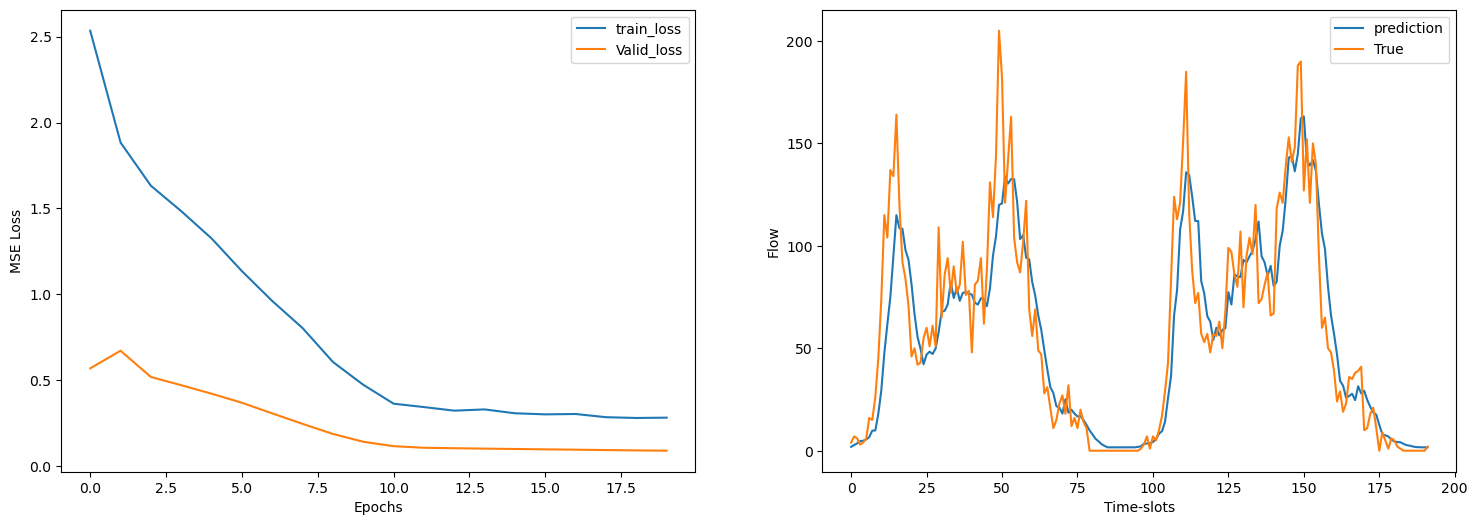

In [43]:
(trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum, window_pred=window_pred)

# Deep Ensemble 
L'idée est de prédire un $\textit{ensemble}$ de modèles, tous avec la même configuration.

On veut quantifier l'incertitude du modèle sur la prédiction. On peut donc définir la "bande d'incertitude" de l'ensemble.

Une manière simple est de regarder la moyenne des prédiction, avec $\pm \lambda$ std

In [6]:
ensemble_size = 5
ensemble = [CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)  for _ in range(ensemble_size)]
Y_preds = []
for model in ensemble:
    (trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum,test = True, plot = False)
    Y_preds.append(test_pred[:,0,0])
L_preds = np.array([y.detach().numpy() for y in Y_preds])


start training


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.3min 
start training
epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.3min 
start training
epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.4min 
start training
epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.3min 
start training
epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.3min 


In [45]:
# Plotting
import matplotlib.pyplot as plt 

def plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96),method='MC dropout'):
    y_mean = L_preds.mean(axis = 0)
    y_std = L_preds.std(axis = 0)
    fig, ax = plt.subplots(figsize = (18,6))
    pred_mean = y_mean[window_pred]
    pred_std = y_std[window_pred]
    y_true = Y_true[window_pred]

    ax.plot(np.arange(len(pred_mean)),pred_mean, label = f'mean prediction',alpha=1, color='#86cfac')
    ax.plot(np.arange(len(y_true)),y_true[:,0,0],label = 'True')

    if method == 'MC dropout':
        for alpha in [1,2,3]:
            lower = pred_mean-alpha*pred_std
            upper = pred_mean+alpha*pred_std
            grid = np.arange(len(pred_mean)).ravel()
            ax.fill_between(grid,lower,upper, label = f'range {alpha} std',alpha=0.6/alpha, color='#86cfac')

    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Flow')
    ax.legend()

    plt.show()

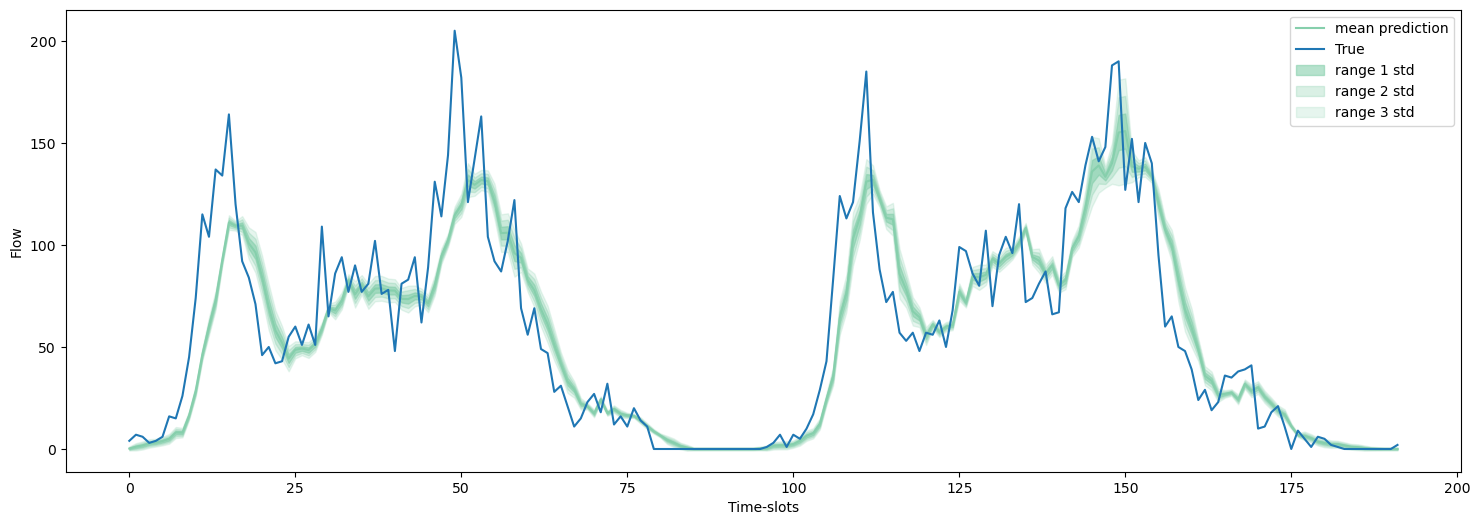

In [7]:
plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96))

# Monte Carlo Dropout
En fait, la technique précédente de l'ensemble Learning est efficace mais très couteuse. C'est pourquoi il faut en définir d'autres.

La Monte Carlo Dropout propose d'utiliser une architecture avec des dropout, et une fois qu'elle est entrainer, utiliser le test avec les dropout actif. Il suffit alors de générer une centaine de test, sur ce même modèle déjà entrainé. 

**Limites et Discussions** On pourrait dire qu'on 'limite les performances du modèles' à chaque fois qu'on passe la dataset de test dans le model avec dropout. 
Problèmes de définission mathématiques. Aleatoric et Epistemic Uncertainty ne sont pas définies rigoureusement. Il y a une discussion a ce propopos [reddit](https://www.reddit.com/r/MachineLearning/comments/7bm4b2/d_what_is_the_current_state_of_dropout_as/), où ils parlent de Risk et d'Uncertainty, de ce qui est capturé par le MC dropout, et de leur différences. Risk et Uncertainty sont deux choses fondamentalements différentes, que l'on peut définir précisément dans le contexte de la Bayesian Inference. [Gal & Ghahramani, 2016](https://arxiv.org/pdf/1506.02142.pdf) ont considéré que le test-time dropout pouvait être considéré comme une Baysian approximation. [Osband 2016](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf) a publié une note, et utilise une [figure](http://htmlpreview.github.io/?https://github.com/yaringal/HeteroscedasticDropoutUncertainty/blob/master/demos/homoscedastic_dropout_reg_DM_relu.html) intéressante. Il explique que de nombreuses méthodes présentée comme approximation de l'uncertainty d'un model sont en fait une approximation du risk du model. Il discute aussi de la différence entre distribution à posteriori de la moyenne, et distribution de la sortie d'un model. Il identifique :
- le risk comme quelque chose d'inhérent à la stochasticité du model   (Le lancé d'une pièce présente un risque, une chance sur deux pour être 0 ou 1, et alors un agent apprenant - lanceur ou model ?-  peut être incertain de p)
- l'uncertitude comme une confusion sur les paramètres que l'ont devrait fixer au model (l'incertitude capture la la variabilité de la croyance (à posteriori) du lanceur, et elle peut être résolue par une analyse stat des données)
Dans le cas du lancé de pièce, avec une modélisation plus détaillée de la physique/dynamique derrière le lancé de pièce, on peut réduire le risque, et il peut n'être plus risqué du tout.


### Model.train() a été set au lieu de model.eval(). Je suis sur d'activer les dropouts, mais j'active aussi ici les autres régularisations, que je ne veux pas forcément.

start training


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.4min 


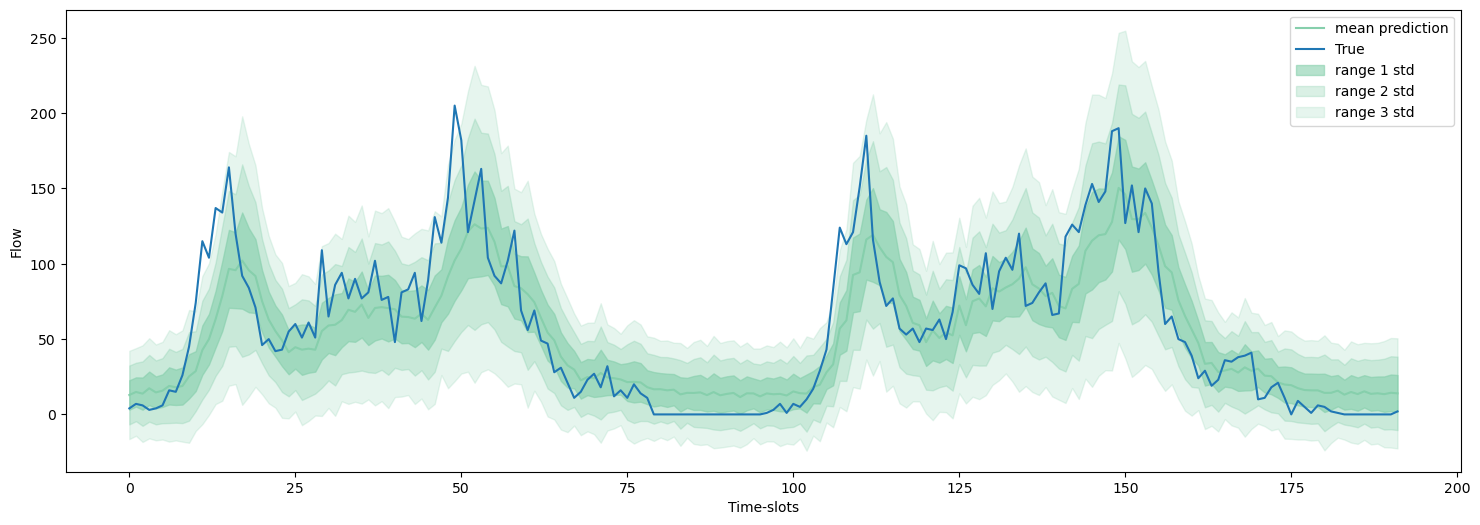

In [46]:
# Load, train and valid model 
model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1,dropout = 0.3)
(trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum,test = True, plot = False)

# Test model N times, with dropout_on : 
L_preds = np.array([trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = True)[0][:,0,0].detach().numpy() for _ in range(100)]) # trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = True)[0] = test_pred
plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96))

# Inductive Conformal Prediction: 
Approche statistique de l'Uncertainty quantification [Vovk et al., 2008](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf).

Permet de construire des bandes d'incertitudes autour de nos prédictions, sans modifier la prédiction du modèle. C'est obtenu en comparant les True / Predicted Values sur un certain ensemble de donnée. On en déduit un quantile empirique. A la comparaison entre la valeur prédite et la valeur réelle on y attribut un score, le 'conformity score', d'où le nom de la méthode.

On veut que pour chaque test sample $(X_{n+1},Y_{n+1})$: 
$$ \mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha$$

C'est à dire, que dans plus de $(1-\alpha)\%$ des cas, notre bande d'incertitude $\hat{C}$ autour de la prédiction, contient $Y_{n+1}$

Le set de donnée est séparée en plusieurs partie.
- **Training set** qui est lui même split en :
    - True Training set
    - Calibration set (un type de set de validation)
Le Calibration set est généralement un set randomly selected. 

### Conformal prediction procedure : 
- On défini le **conformity scores**, qui est ici simplement le residuel : $y - \hat{y}$
- On choisi le quantile $q \in [0,1]$
- On compute le quantile tensor, et il servira à définir la bande sup et bande inf de notre prédiction.

On peut très bien imaginer faire la quantile regression non pas pour l'ensemble des time slot, mais seulement sur des groupes de times slots (dont certains groupes identifiée comme 'problématique', obtenue avec un clustering sur le calendrier, lié à des évenements et des stations ...)

In [47]:
# Let's consider the test dataset as the Calibration dataset
(test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = False)

# Residual: 
resid = torch.abs(Y_true - test_pred)  # Scores

# Conformal quantile:
alpha = 0.025
n = len(test_pred)
q = torch.Tensor([np.ceil((1 - alpha) * (n + 1)) / n]) #  np.ceil((1 - alpha) * (n + 1)) / n  est clairement inutile. Problème dans la fonction
q_tensor = torch.quantile(resid,q,dim = 0) #interpolation = 'higher'

In [48]:
def plot_conformal_bands(test_pred,Y_true,q,q_tensor,window_pred = np.arange(2*96)):
    fig, ax = plt.subplots(figsize = (18,6))
    pred = test_pred[window_pred]
    y_true = Y_true[window_pred]

    ax.plot(np.arange(len(pred)),pred, label = f'mean prediction',alpha=1, color='#86cfac')
    ax.plot(np.arange(len(y_true)),y_true,label = 'True')

    lower = pred-q_tensor
    upper = pred+q_tensor
    grid = np.arange(len(pred)).ravel()
    ax.fill_between(grid,lower,upper, label = f'range quantile {q}',alpha=0.6, color='#86cfac')

    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Flow')
    ax.legend()

    plt.show()

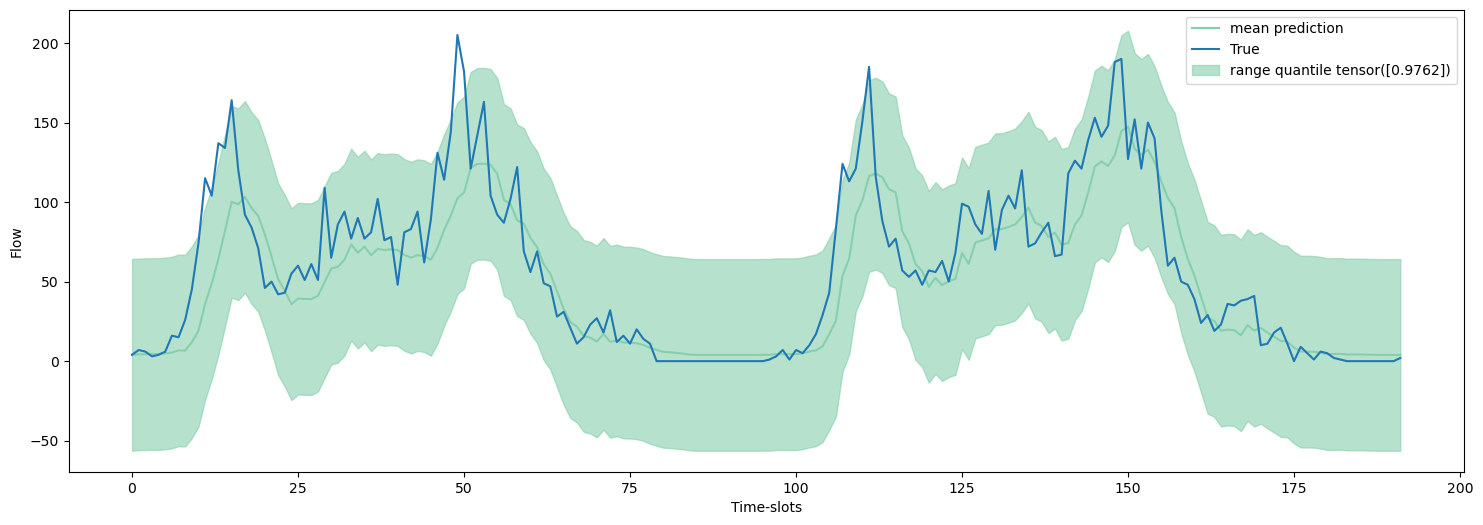

In [49]:
plot_conformal_bands(test_pred[:,0,0],Y_true[:,0,0],q,q_tensor[:,0,0])

# Historical data-based method:
Suppose que les données de trafic suivent une distribution avec des pattern qui se répètent à travers le temps. Le PI serait basé sur leur distribution.

Le PI est alors $$[\mu_{i}^{t} - \alpha * \sigma_{i}^{t} , \mu_{i}^{t} + \alpha * \sigma_{i}^{t}] \phantom{abc} \forall i,t \in \mathcal{N}\times \mathcal{T} $$

Avec : 
- $\mathcal{N}$ l'ensemble des unités spatiales considérés (ex : les 40 stations de métro)
- $\mathcal{T}$ l'ensemble des class temporelle (ex : l'ensemble des lundi 8:30)
- $\alpha$ un coefficient qui sert de sueil (1*std ou 3*std)



In [ ]:
def historical_data_based_method(train_df,method = 'week and hour',time_step_per_hour = 4):
    spatial_units = list(train_df.columns)
    train_df.index.name = 'datetime'
    train_df = train_df.reset_index()

    # Add columns weekday, hour, minutes : 
    if method == 'week and hour':
        train_df['weekday'] = train_df.datetime.dt.weekday
        train_df['hour'] = train_df.datetime.dt.hour
        groupby_col = ['weekday','hour']
        if time_step_per_hour > 1:
            train_df['minute'] = train_df.datetime.dt.minute
            groupby_col = groupby_col + ['minute']

    # Get 'mean' and 'std' for each spatial unit and temporal class (weekday,hour,min): 
    train_df = train_df.groupby(groupby_col).agg({c : ['mean','std'] for c in spatial_units} )
    
    return(train_df)

# Exemple to use it : 
if False:
    train_df = dataset_in.df_train
    train_df = historical_data_based_method(train_df)
    train_df.head()

## Deep Quantile Regression 

In [50]:
class QuantileLoss(nn.Module):
    def __init__(self,quantiles):
        super().__init__()
        self.quantiles = quantiles
    
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []

        # y-^y 
        errors = target - preds       #Soustraction sur la dernière dimension, à priori target 1 sortie et prediction len(quantiles) sorties
        losses = torch.max(q*errors,(q-1)*errors) # Récupère le plus grand des deux écart 
        
        # Prends la moyenne de toute les erreurs
        loss = torch.mean(torch.sum(losses,dim = -1))   #  Loss commune pour toutes les stations. sinon loss par stations : torch.mean(torch.sum(losses,dim = -1),dim = 0)

        return(loss)

In [52]:
quantiles = [0.025,0.1,0.5,0.9,0.975]
C_outs[-1] = len(quantiles)  #On mets autant de sortie qu'on veut calculer de quanitles
model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1,dropout = 0.3)
quantile_loss = QuantileLoss(quantiles)  # On associe notre nouvelle loss

trainer = train_valid_model(model,data_loader,epochs,lr,momentum,loss_function = quantile_loss)

start training


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.4min 


In [53]:
(test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [54]:
fig, ax = plt.subplots()
restricted_pred, restricted_true = test_pred[window_pred],Y_true[window_pred]
xaxis = len(restricted_pred)

# plot true
ax.plot(xaxis,restricted_true, label = 'True', color = 'black')

# 

torch.Size([1133, 40, 5])

## Bayesian Uncertainty Quantification: 
Vient de ce papier [Weight Uncertainty in Neural Networks, Blundell et al., 2015](https://arxiv.org/pdf/1505.05424.pdf)
- Modélise l'incertitude des paramètres du modèles en utilisant une fonction de vraissemblance. 
- Compute l'incertitude sur la donnée en approchant la distribution de proba sur les sortie du modèle

Dans le papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf) : consdièrent la distribution appriori comme loi normale (Gaussian priori distribution with 0 mean and 1 variance), et un MC sampling de 50.